In [ ]:
import argparse
import os
import sys 
sys.path.insert(0, '/raven/u/noka/VAEEG')  # or use relative: os.path.abspath('..')
from src.model.opts.dataset import ClipDataset
from src.model.net.modelA import VAEEG, re_parameterize
import yaml
import torch
import numpy as np
from collections import OrderedDict
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
def load_model(model: nn.Module, ckpt_file: str):
    """
    Loads a checkpoint saved from single- or multi-GPU training into a model
    running on a single GPU or CPU. Returns any auxiliary info found.
    """
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    ckpt = torch.load(ckpt_file, map_location=device)
    sd = ckpt["model"]

    # Remove "module.", if saved under DataParallel/DDP"
    if next(iter(sd)).startswith("module."):
        sd = {k[len("module."):]: v for k, v in sd.items()}
    model.load_state_dict(sd)
    model.to(device)
    
    return device

In [3]:
def init_model(in_channels, z_dim, deterministic, ckpt_file, negative_slope=0.2, decoder_last_lstm=False): 
    model = VAEEG(in_channels=in_channels,
                    z_dim=z_dim,
                    negative_slope=negative_slope,
                    decoder_last_lstm=decoder_last_lstm,
                    deterministic=deterministic)
    device = load_model(model, ckpt_file=ckpt_file)
    return model, device

In [4]:
class ClipDatasetDeterministic(ClipDataset):
    """
    Same as ClipDataset, but uses a provided start index per item
    so that bands can be paired deterministically.
    """
    def __init__(self, data_dir, band_name, clip_len=256, seed=42, n_len=1280, n_items=2575060):
        super().__init__(data_dir=data_dir, band_name=band_name, clip_len=clip_len)
        rng = np.random.RandomState(seed)
        starts = rng.randint(0, n_len - clip_len + 1, size=n_items)
        self.starts = np.asarray(starts, dtype=np.int64)
        if np.any(self.starts < 0) or np.any(self.starts > self.n_len - self.clip_len):
            raise ValueError(f"Invalid start indices for band={band_name}")

    def __getitem__(self, index):
        idx = int(self.starts[index])
        if self.is_3d:
            x = self.data[index, :, idx: idx + self.clip_len]
        else:
            x = self.data[index:index+1, idx: idx + self.clip_len]
        return x

In [5]:
def init_dl(data_root, band, batch_size=1024, num_workers=1, shuffle=False): 
    # Dataloader for this band
    ds = ClipDatasetDeterministic(
        data_dir=data_root,
        band_name=band
    )
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )
    return loader

In [6]:
def pearson_index(x, y, dim=-1, eps=1e-8):
    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        xy = x * y
        xx = x * x
        yy = y * y

        mx  = np.mean(x, axis=dim, keepdims=False)
        my  = np.mean(y, axis=dim, keepdims=False)
        mxy = np.mean(xy, axis=dim, keepdims=False)
        mxx = np.mean(xx, axis=dim, keepdims=False)
        myy = np.mean(yy, axis=dim, keepdims=False)

        num = mxy - mx * my
        den = np.sqrt(np.clip(mxx - mx**2, a_min=0.0, a_max=None) *
                      np.clip(myy - my**2, a_min=0.0, a_max=None) + eps)
        return num / den

    else:
        # PyTorch backend
        xy = x * y
        xx = x * x
        yy = y * y

        mx  = x.mean(dim, keepdim=False)
        my  = y.mean(dim, keepdim=False)
        mxy = xy.mean(dim, keepdim=False)
        mxx = xx.mean(dim, keepdim=False)
        myy = yy.mean(dim, keepdim=False)

        num = mxy - mx * my
        den = torch.sqrt(torch.clamp(mxx - mx**2, min=0.0) *
                         torch.clamp(myy - my**2, min=0.0) + eps)
        return num / den


def evaluate(model, loader, device):
    model.eval()

    sse = 0.0                 # sum of squared errors over the whole dataset
    n_mse = 0                 # total number of elements contributing to MSE

    sum_r = 0.0               # sum of Pearson r over all (sample,channel)
    n_r = 0                   # total count of r values

    first_inpt = None
    first_otpt = None

    with torch.no_grad():
        for step, x in enumerate(loader, 1):
            x = x.to(device)                                # (B,C,T) or (B,1,T)
            mu, log_var, xbar = model(x)                    # xbar same shape as x

            # accumulate SSE with reduction='sum'
            batch_sse = F.mse_loss(x, xbar, reduction="sum")
            sse += batch_sse.item()
            n_mse += x.numel()

            # --- Pearson (average over samples & channels) ---
            r = pearson_index(x, xbar, dim=-1)              # shape (B,C) if input is (B,C,T)
            sum_r += r.sum().item()
            n_r += r.numel()

            if step == 1:
                first_inpt = x.detach().cpu().numpy()
                first_otpt = xbar.detach().cpu().numpy()
    avg_mse = sse / n_mse if n_mse > 0 else float("nan")
    avg_pcc = sum_r / n_r if n_r > 0 else float("nan")

    return avg_mse, avg_pcc, first_inpt, first_otpt

In [7]:
def get_reconstruction(model, loader, device):
    model.eval()
    num_samples = len(loader.dataset)
    rec = np.zeros((num_samples, 256), dtype=np.float32)
    idx = 0
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            mu, log_var, xbar = model(x)
            bs = xbar.size(0)
            rec[idx:idx + bs, :] = xbar.cpu().numpy().squeeze()
            idx += bs
    return rec 

In [2]:
# Define parameters for testing
bands = ["delta", "theta", "alpha", "low_beta", "high_beta"]
z_dim = 50
epoch = 50
in_channels=1
seed = 42 
deterministic = True
if deterministic: 
    ckpt_root = "/raven/u/noka/VAEEG/models_new/vanilla"
else: 
    ckpt_root = "/raven/u/noka/VAEEG/models_new/variational"
data_dir = "/ptmp/noka/new_data/"

In [3]:
# Dictionaries for losses and reconstructions 
ae_recs = {} 
vae_recs = {}
pca_recs = {}
ae_losses = {}
vae_losses = {}
pca_losses = {}
pca_train = {}
pca_test = {}

In [39]:
# Evaluate models on test set
for band in tqdm(bands): 
    ckpt_file = os.path.join(ckpt_root, band, f"z{z_dim}", f"ckpt_epoch_{epoch}.ckpt")
    model, device = init_model(in_channels=in_channels, z_dim=z_dim, deterministic=deterministic, ckpt_file=ckpt_file)
    loader = init_dl(os.path.join(data_dir, "test"), band)
    rec, pcc, input_signal, output_signal = evaluate(model, loader, device)
    if deterministic: 
        ae_losses[band] = rec, pcc, input_signal, output_signal
    else: 
        vae_losses[band] = rec, pcc, input_signal, output_signal

100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


In [40]:
# Get reconstructions 
for band in tqdm(bands):
    ckpt_file = os.path.join(ckpt_root, band, f"z{z_dim}", f"ckpt_epoch_{epoch}.ckpt")
    model, device = init_model(in_channels=in_channels, z_dim=z_dim, deterministic=deterministic, ckpt_file=ckpt_file)
    loader = init_dl(os.path.join(data_dir, "test"), band)
    rec = get_reconstruction(model=model, loader=loader, device=device)
    if deterministic: 
        ae_recs[band] = rec
    else: 
        vae_recs[band] = rec 

100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


In [4]:
# Prepare data for PCA fitting
rng_test = np.random.RandomState(seed)
starts_test = rng_test.randint(0, 1280 - 256 + 1, size=288182)
rng_train = np.random.RandomState(seed)
starts_train = rng_train.randint(0, 1280 - 256 + 1, size=2575060)
for band in tqdm(bands): 
    band_train = np.load(os.path.join(data_dir, "train", f"{band}.npy"))
    band_test = np.load(os.path.join(data_dir, "test", f"{band}.npy"))
    orig_train = np.zeros((band_train.shape[0], 256), dtype=band_train.dtype)
    orig_test = np.zeros((band_test.shape[0], 256), dtype=band_test.dtype)
    for i in range(band_train.shape[0]):
        orig_train[i] = band_train[i, starts_train[i]:starts_train[i] + 256]
    for i in range(band_test.shape[0]):
        orig_test[i] = band_test[i, starts_test[i]:starts_test[i] + 256]
    pca_train[band] = orig_train
    pca_test[band] = orig_test

100%|██████████| 5/5 [01:47<00:00, 21.49s/it]


In [8]:
pca_latents = {}
for band in tqdm(bands):
    data_train = pca_train[band]   # (N_train, f)
    pca = PCA(n_components=50, random_state=42)
    pca.fit(data_train)
    print("Explained variance ratio sum:", np.sum(pca.explained_variance_ratio_))

    data_test = pca_test[band]     # (N_test, f)
    latents = pca.transform(data_test)
    recs    = pca.inverse_transform(latents)

    pca_recs[band] = recs
    pca_latents[band] = latents
    mse = mean_squared_error(data_test, recs)
    pr   = pearson_index(data_test, recs)
    pca_losses[band] = mse, pr

  0%|          | 0/5 [00:00<?, ?it/s]

Explained variance ratio sum: 0.99999994


 20%|██        | 1/5 [00:01<00:05,  1.39s/it]

Explained variance ratio sum: 1.0


 40%|████      | 2/5 [00:02<00:04,  1.34s/it]

Explained variance ratio sum: 0.9999999


 60%|██████    | 3/5 [00:04<00:02,  1.34s/it]

Explained variance ratio sum: 0.9999999


 80%|████████  | 4/5 [00:05<00:01,  1.35s/it]

Explained variance ratio sum: 1.0


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


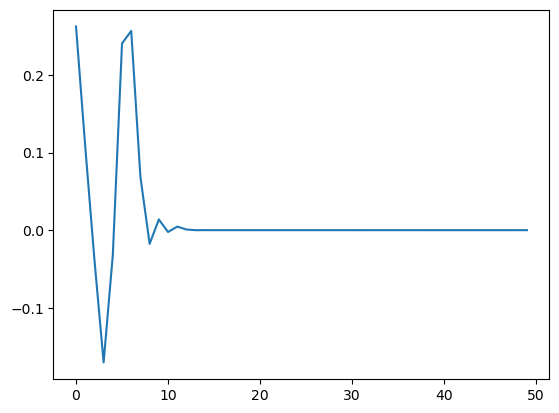

In [16]:
mean_pca = np.mean(pca_latents["delta"], axis=0)
plt.plot(mean_pca)
plt.show()

In [78]:
vae_rec_sum = sum(vae_recs.values())
ae_rec_sum = sum(ae_recs.values())
pca_rec_sum = sum(pca_recs.values())
whole = np.load(os.path.join(data_dir, "test/whole.npy"))
orig = np.zeros((whole.shape[0], 256), dtype=whole.dtype)
for i in range(whole.shape[0]):
    orig[i] = whole[i, starts_test[i]:starts_test[i] + 256]

In [79]:
# Get MSE and PCC on full reconstruction
ae_mse = np.mean((orig - ae_rec_sum) ** 2)
vae_mse = np.mean((orig - vae_rec_sum) ** 2)
pca_mse = np.mean((orig - pca_rec_sum) ** 2)
ae_cors = []
vae_cors = []
pca_cors = []
for i in range(len(orig)):
    ae_r, _ = pearsonr(orig[i], ae_rec_sum[i])
    vae_r, _ = pearsonr(orig[i], vae_rec_sum[i])
    pca_r, _ = pearsonr(orig[i], pca_rec_sum[i])
    ae_cors.append(ae_r)
    vae_cors.append(vae_r)
    pca_cors.append(pca_r)

ae_corr = np.mean(ae_cors)
vae_corr = np.mean(vae_cors)
pca_corr = np.mean(pca_cors) 

In [111]:
print(f"MSE for AE: {ae_mse:.3f}, PCC for AE: {ae_corr:.3f}")
print(f"MSE for VAE: {vae_mse:.3f}, PCC for AE: {vae_corr:.3f}")
print(f"MSE for PCA: {pca_mse:.3f}, PCC for PCA: {pca_corr:.3f}")

MSE for AE: 6.721, PCC for AE: 0.987
MSE for VAE: 7.797, PCC for AE: 0.986
MSE for PCA: 4.966, PCC for PCA: 0.993


In [115]:
for band in bands:  
    print(f"{pca_losses[band][0]:.3f}, {ae_losses[band][1]:.3f}")

0.000, 0.999
0.000, 0.996
0.000, 0.984
0.000, 0.986
0.000, 0.970


In [80]:
labels = np.load("/ptmp/noka/labels/test.npy") 

In [81]:
seiz_indeces = np.where(labels == 1)[0]
bkgd_indeces = np.where(labels == 0)[0]

In [82]:
def plot_full_recon(rec, orig, sample_indeces, save_path, fs=256):
    # Global aesthetics suitable for a thesis
    plt.rcParams.update({
        "font.size": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
    }) 
    fig, axes = plt.subplots(2, 1, figsize=(3.2, 7), constrained_layout=True, sharey=False)
    for j, idx in enumerate(sample_indeces):
        ax = axes[j]
        x = np.arange(fs) / fs

        # Plot input and reconstruction (use simple grayscale for print-friendly output)
        h1, = ax.plot(x, orig[idx],  linewidth=1.2, color="black")
        h2, = ax.plot(x, rec[idx],   linewidth=1.2, color="darkorange", linestyle="--")

        # Title with metrics
        if j == 0: 
            ax.set_title("Seizure")
        else: 
            ax.set_title("Background")
        ax.set_ylabel("Amplitude ($ \mu V$)")
        ax.set_xlabel("Time (s)")
 
    plt.savefig(save_path)
    plt.show()

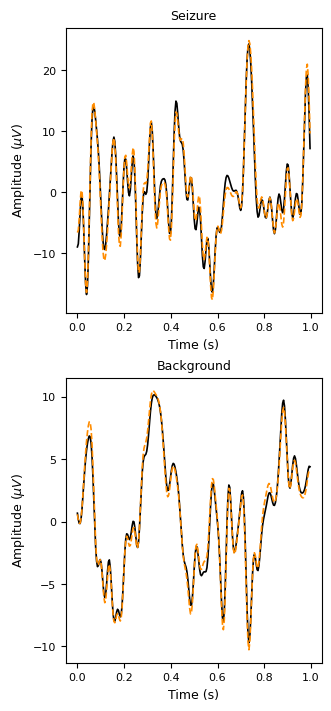

In [83]:
rng = np.random.default_rng(seed=seed)
seiz_idx = rng.choice(seiz_indeces)
bkgd_idx = rng.choice(bkgd_indeces) 
plot_full_recon(pca_rec_sum, orig, [seiz_idx, bkgd_idx], save_path="full_reconstruction_pca.pdf")

In [95]:
def plot_band_recon(reconstructions, pca_test, sample_idx, save_path, fs=256):
    # Global aesthetics suitable for a thesis
    plt.rcParams.update({
        "font.size": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
    })

    fig, axes = plt.subplots(2, 1, figsize=(3.2, 7), constrained_layout=True, sharey=False)
    bands=["delta", "high_beta"]
    for j, band in enumerate(bands):
        ax = axes[j]
        recs = reconstructions[band]
        origs = pca_test[band]

        orig, rec = origs.squeeze()[sample_idx], recs.squeeze()[sample_idx]
        x = np.arange(len(orig)) / fs

        # Plot input and reconstruction (use simple grayscale for print-friendly output)
        h1, = ax.plot(x, orig,  linewidth=1.2, color="black")
        h2, = ax.plot(x, rec,   linewidth=1.2, color="darkorange", linestyle="--")

        # Title with metrics
        ax.set_title(f"{band}")
        ax.set_ylabel("Amplitude ($\mu V$)")
        ax.set_xlabel("Time (s)")

    plt.savefig(save_path)
    plt.show()

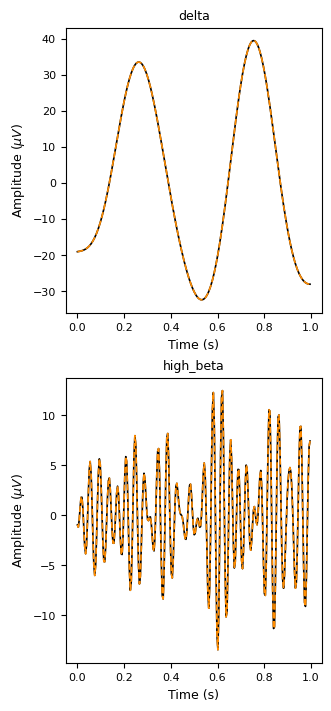

In [97]:
sample_idx = 1000
plot_band_recon(pca_recs, pca_test, sample_idx=sample_idx, save_path="reconstruction_pca.pdf") 